# Python On Resonance (PyOR)

Author: Vineeth Thalakottoor \
Email: vineethfrancis.physics@gmail.com

## Tutorial 10: Correlation Spectroscopy (COSY) Part 2 J Coupling

In this tutorial we consider Two H1 spins (Homonuclear)

Reference book - "NMR: The Toolkit, How Pulse Sequences Work" by P.J Hore, J.A. Jones and S. Wimperis

## Load Python packages and define path to the source file "PythonOnResonance.py"

In [159]:
pathSource = '/media/HD2/Vineeth/PostDoc_Simulations/Github/PyOR_G/Source'

In [160]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import sys
sys.path.append(pathSource)

import PythonOnResonance as PyOR

import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib notebook
import sympy as sp
from sympy import *
from IPython.display import display, Math, Latex

## Generating Spin System

In [161]:
"""
Define Spin quantum numbers of your spins in "Slist1".
Slist1[0] is spin of first particle and Slist1[1] is spin of second particle.
""";

Slist1 = [1/2,1/2]

In [162]:
"""
Define Planck constant equals 1. 
Because NMR spectroscopists are more interested to write Energy in frequency units. 
if False then hbarEQ1 = hbar
""";

hbarEQ1 = True

In [163]:
"""
Generate Spin Operators
""";

System = PyOR.Numerical_MR(Slist1,hbarEQ1)

"""
Sx, Sy and Sz Operators
""";
Sx,Sy,Sz = System.SpinOperator()

"""
S+ and S- Operators
""";
Sp,Sm = System.PMoperators(Sx,Sy)

## Zeeman Hamiltonian in Lab Frame

In [164]:
"""
Gyromagnetic Ratio
Gamma = [Gyromagnetic Ratio spin 1, Gyromagnetic Ratio spin 1, ...]
""";
Gamma = [System.gammaH1,System.gammaH1,System.gammaH1]

"""
Define the field of the spectromter, B0 in Tesla.
"""
B0 = 9.4

"""
Define the chemical Shift of individual spins
Offset = [chemical Shift spin 1, chemical Shift spin 1, ..]
"""
Offset = [150, 200] # Offset frequency in Hz

"""
Function "LarmorF" give the list Larmor frequencies of individual spins in lab frame
"""
LarmorF = System.LarmorFrequency(Gamma,B0,Offset)

Hz = System.Zeeman(LarmorF,Sz)

Larmor Frequency in MHz:  [-400.22816765 -400.22821765]


## Initialize Density Matrix

In [165]:
"""
We will generate Initial Density Matrix in two ways: 
First we will generate a density matrix as we prefer say, Sz. 
Second we will create density matrix at thermal equlibrium

First Case
""";

Thermal_DensMatrix = False 

if Thermal_DensMatrix:
    Hz_EnUnit = System.Convert_FreqUnitsTOEnergy(Hz)
    HT_approx = False # High Temperature Approximation is False
    T = 300 # Temperature in Kelvin
    rho_in = System.EqulibriumDensityMatrix(Hz_EnUnit,T,HT_approx)
    rhoeq = rho_in.copy()   
else:
    rho_in = Sz[0] # np.sum(Sz,axis=0) # Initial Density Matrix
    rhoeq = np.sum(Sz,axis=0)  # Equlibrium Density Matrix   
    print("Trace of density metrix = ", np.trace(rho_in))

Trace of density metrix =  0j


In [166]:
'''
Operator Basis
Option: 'Cartesian spin half' and 'PMZ spin half'
All the 16 operator basis are loaded in the matrix, 'B_car'
''';
Basis = 'Cartesian spin half'
B_car = System.TwoSpinOP(Sx,Sy,Sz,Sp,Sm,Basis)

<IPython.core.display.Latex object>

In [167]:
'''
B_car[0] = B0 = 1/2 E,
B_car[1] = B1 = Ix,
so on...
Hope you understand.
'''
System.OperatorBasis('Cartesian')

<IPython.core.display.Latex object>

In [168]:
'''
A density matrix (rho) can be written as:
rho = a B0 + b B1 + c B2 + ...
where B0, B1,... are operator basis.

Components of initial density matrix in cartesian basis
''';
Matrix(System.DensityMatrix_Components(B_car,rho_in))

Matrix([
[  0],
[  0],
[  0],
[1.0],
[  0],
[  0],
[  0],
[  0],
[  0],
[  0],
[  0],
[  0],
[  0],
[  0],
[  0],
[  0]])

## Zeeman Halitonian in Rotating Frame

In [169]:
OmegaRF = [-System.gammaH1*B0,-System.gammaH1*B0,-System.gammaH1*B0]
Hz = System.Zeeman_RotFrame(LarmorF, Sz, OmegaRF)

## J Coupling Hamiltonian

In [170]:
'''
Define J couplings between individual spins
'''
Jlist = np.zeros((len(Slist1),len(Slist1)))
Jlist[0][1] = 10.5
Hj = System.Jcoupling_Weak(Jlist,Sz)

## Total Hamiltonian

In [171]:
Htotal = Hz + Hj

## Relaxation Constant

In [172]:
# Define longitudinal and transverse Relaxation
R1 = 0
R2 = 5
System.Relaxation_Constants(R1,R2)
Rprocess = "Phenomenological"

## 90 deg on spin 1

In [173]:
rho = System.Rotate_H(rho_in,90,Sx[0])  

In [174]:
# Components of density matrix in cartesian basis
Matrix(System.DensityMatrix_Components(B_car,rho))

Matrix([
[   0],
[   0],
[-1.0],
[   0],
[   0],
[   0],
[   0],
[   0],
[   0],
[   0],
[   0],
[   0],
[   0],
[   0],
[   0],
[   0]])

## Delay Evolution

In [175]:
dt = 0.0005 #50e-6
delay = 1/(4.0 * Jlist[0][1]) # 1/2J
Dpoints = int(delay/dt)
print("Npoints = ", Dpoints)
method = "ODE Solver"

start_time = time.time()
t, rho_t = System.Evolution_H(rhoeq,rho,Sx,Sy,Sz,Sp,Sm,Htotal,dt,Dpoints,method,Rprocess)
end_time = time.time()
timetaken = end_time - start_time
print("Total time = %s seconds " % (timetaken))

Npoints =  47
Total time = 0.22338151931762695 seconds 


In [176]:
# Components of density matrix in cartesian basis
Matrix(System.DensityMatrix_Components(B_car,rho_t[-1]))

Matrix([
[                 0],
[ 0.105363913865696],
[ 0.665241572157318],
[                 0],
[                 0],
[                 0],
[                 0],
[-0.651793940267898],
[ 0.103234018970891],
[                 0],
[                 0],
[                 0],
[                 0],
[                 0],
[                 0],
[                 0]])

## 90 deg Pulse on all spins

In [177]:
rho1 = System.Rotate_H(rho_t[-1],90,np.sum(Sx,axis=0)) 

In [178]:
# Components of density matrix in cartesian basis
Matrix(System.DensityMatrix_Components(B_car,rho1))

Matrix([
[                 0],
[ 0.105363913865696],
[                 0],
[ 0.665241572157318],
[                 0],
[                 0],
[                 0],
[                 0],
[                 0],
[                 0],
[-0.103234018970891],
[                 0],
[                 0],
[ 0.651793940267898],
[                 0],
[                 0]])

## Detection

In [179]:
AQ = 3.0
Npoints = int(AQ/dt)
print("Npoints = ", Npoints)
method = "ODE Solver"

start_time = time.time()
t1, rho_t1 = System.Evolution_H(rhoeq,rho1,Sx,Sy,Sz,Sp,Sm,Htotal,dt,Npoints,method,Rprocess)
end_time = time.time()
timetaken = end_time - start_time
print("Total time = %s seconds " % (timetaken))

Npoints =  6000
Total time = 24.035877466201782 seconds 


In [180]:
# Components of density matrix in cartesian basis
Matrix(System.DensityMatrix_Components(B_car,rho_t1[-1]))

Matrix([
[                   0],
[                   0],
[                   0],
[   0.665241572157318],
[-5.70965686864341e-5],
[                   0],
[                   0],
[                   0],
[ -5.8275031779214e-5],
[                   0],
[                   0],
[                   0],
[                   0],
[0.000360449150631883],
[                   0],
[                   0]])

## Expectation Value

In [181]:
det1 = (B_car[1] + B_car[4]) + 1j * (B_car[2] + B_car[5])
det2 = B_car[7] + 1j * B_car[8] 
det3 = B_car[13]

In [182]:
t1, Ex_det1 = System.Expectation_H(rho_t1,det1,dt,Npoints)
t1, Ex_det2 = System.Expectation_H(rho_t1,det2,dt,Npoints)
t1, Ex_det3 = System.Expectation_H(rho_t1,det3,dt,Npoints)

## Fourier Transform

In [183]:
fs = 1.0/dt
freq, spectrum1 = System.FourierTransform(Ex_det1,fs,5)
freq, spectrum2 = System.FourierTransform(Ex_det2,fs,5)
freq, spectrum3 = System.FourierTransform(Ex_det3,fs,5)

## Ploting

<IPython.core.display.Javascript object>


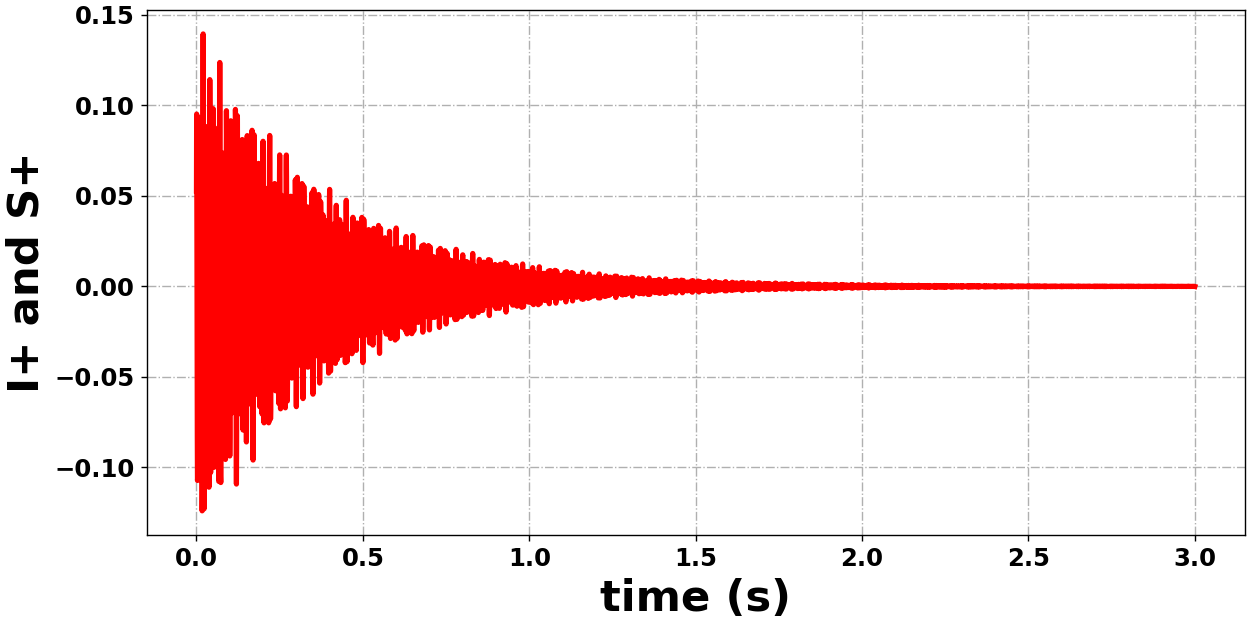

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


In [184]:
System.Plotting(1,t1,Ex_det1,"time (s)","I+ and S+","red")

<IPython.core.display.Javascript object>


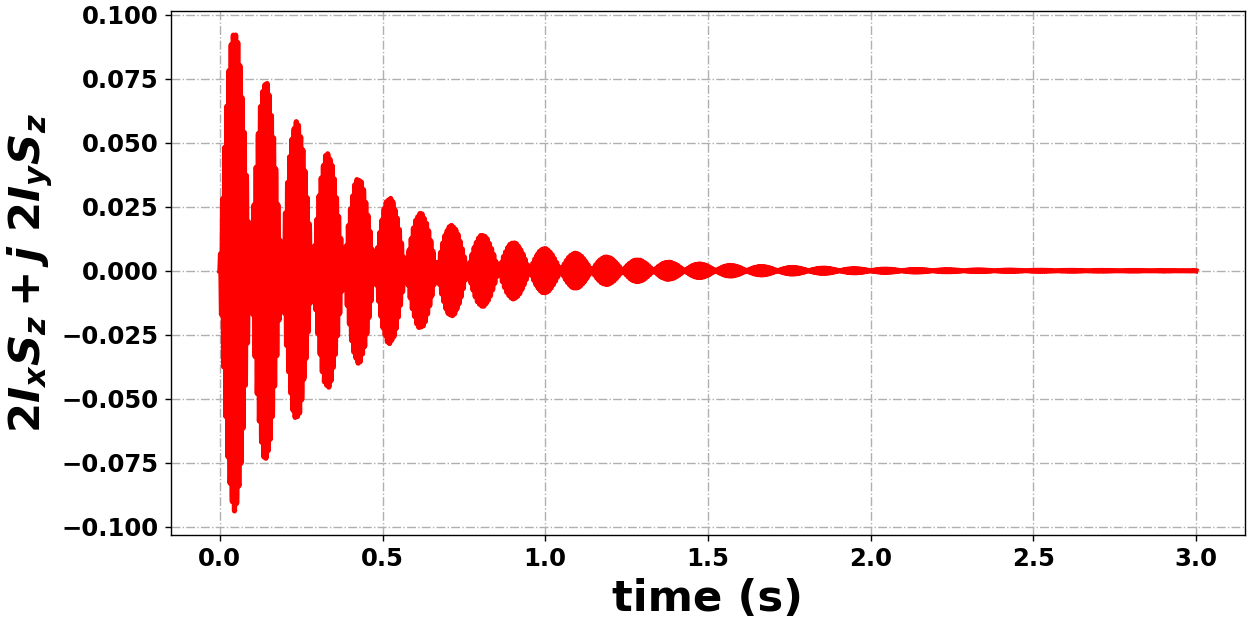

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


In [185]:
System.Plotting(2,t1,Ex_det2,"time (s)",r"$2I_{x}S_{z} + j \ 2I_{y}S_{z}$","red")

<IPython.core.display.Javascript object>


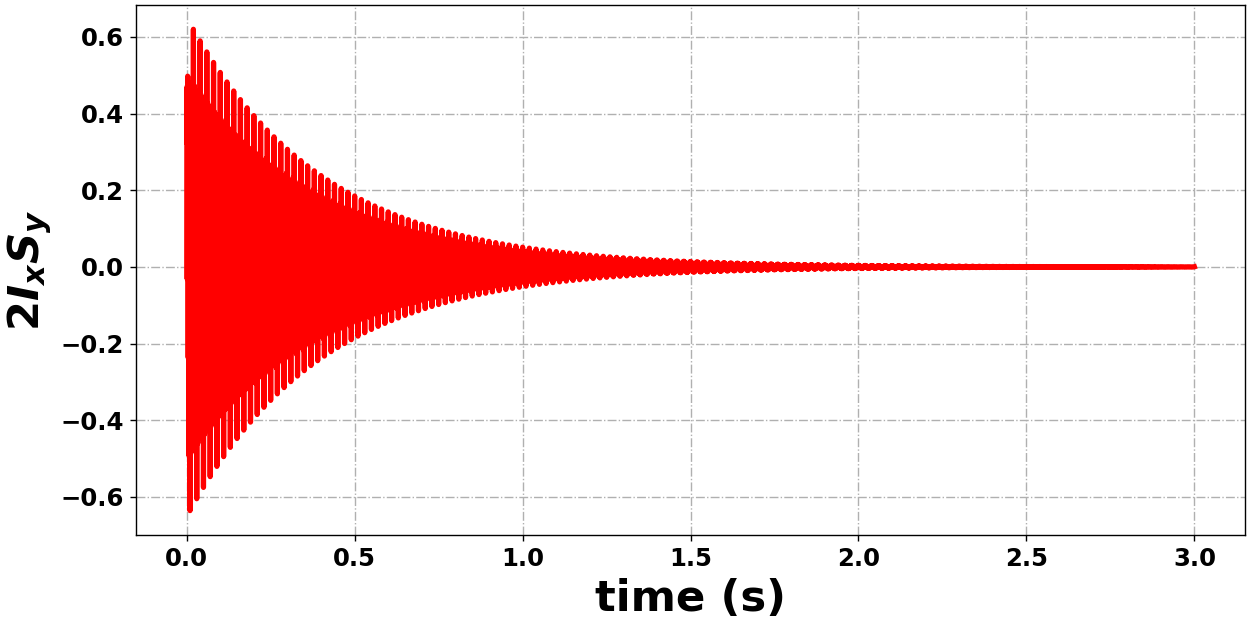

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


In [186]:
System.Plotting(3,t1,Ex_det3,"time (s)",r"$2I_{x}S_{y}$","red")

<IPython.core.display.Javascript object>


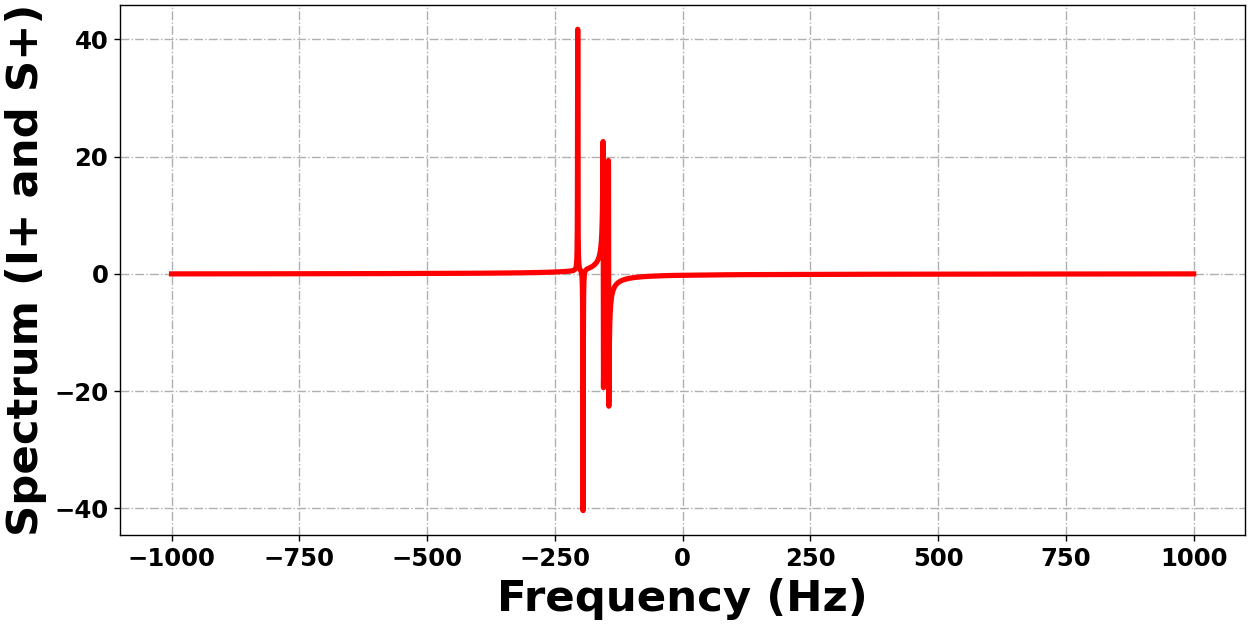

No handles with labels found to put in legend.


In [187]:
PH0 = -45.0
spectrum_PH0 = System.PhaseAdjust_PH0(spectrum1,PH0)
System.Plotting(4,freq,spectrum_PH0.real,"Frequency (Hz)",r"Spectrum (I+ and S+)","red")

<IPython.core.display.Javascript object>


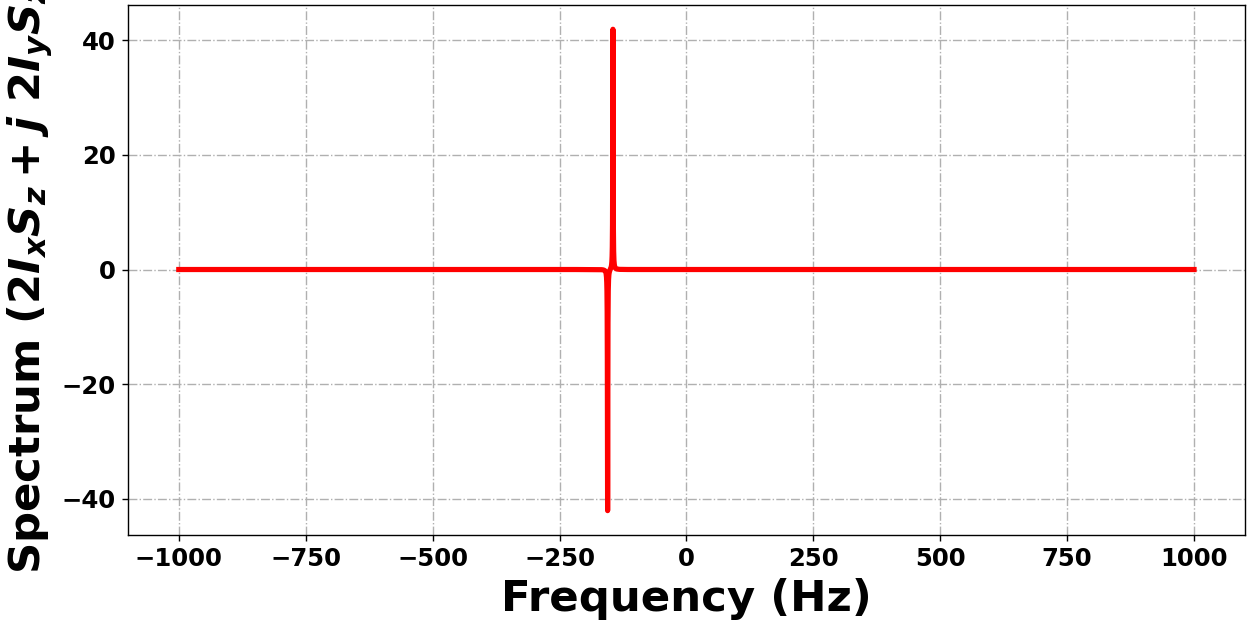

No handles with labels found to put in legend.


In [188]:
PH0 =0.0
spectrum_PH0 = System.PhaseAdjust_PH0(spectrum2,PH0)
System.Plotting(5,freq,spectrum_PH0.real,"Frequency (Hz)",r"Spectrum ($2I_{x}S_{z} + j \ 2I_{y}S_{z}$)","red")

<IPython.core.display.Javascript object>


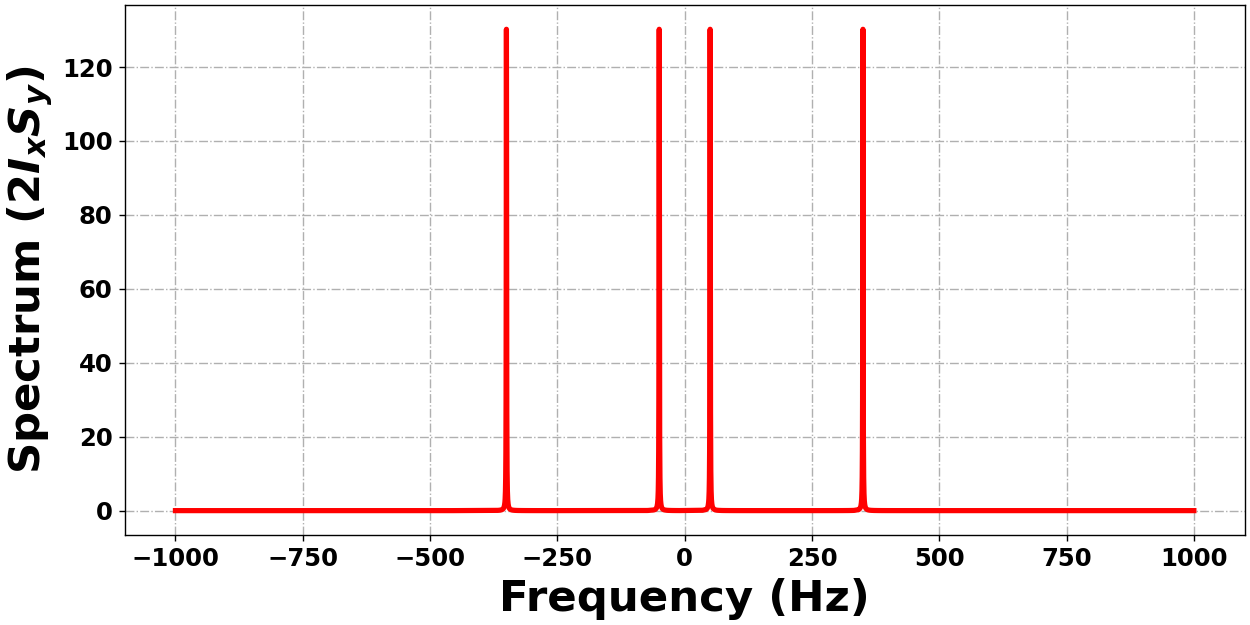

No handles with labels found to put in legend.


In [189]:
PH0 = 0.0
spectrum_PH0 = System.PhaseAdjust_PH0(spectrum3,PH0)
System.Plotting(64,freq,spectrum_PH0.real,"Frequency (Hz)",r"Spectrum ($2I_{x}S_{y}$)","red")

## Any suggestion? write to me
If you see something is wrong please write to me, so that the PyOR can be error free.

vineethfrancis.physics@gmail.com